In [43]:
import os
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import random
from datetime import datetime, timedelta

In [44]:
os.environ["JAVA_HOME"] = "/nix/store/8drvwqmcxh2rvasgr7visxrgfjxnd3an-openjdk-11.0.19+7"

spark = SparkSession.builder \
    .appName("SqlQuery") \
    .master("local[*]") \
    .getOrCreate()


In [20]:
users = ["alice@gmail.com", "bob@gmail.com", "carol@gmail.com", "dave@gmail.com", "eve@gmail.com"]
days = [20240501 + i for i in range(8)]

records = []
used_pairs = set()

while len(records) < 100:
    day = random.choice(days)
    from_user = random.choice(users)
    to_user = random.choice(users)
    if from_user != to_user and (day, from_user, to_user) not in used_pairs:
        used_pairs.add((day, from_user, to_user))
        records.append((day, from_user, len(records) + 1, to_user))

df_emails = pd.DataFrame(records, columns=["day", "from_user", "id", "to_user"])
df_emails
df_spark = spark.createDataFrame(df_emails)
df_spark.createOrReplaceTempView("google_gmail_emails")
df_spark.show()

/nix/store/ay67m3dhqwxnf3qna4xj3ywnknxya2k4-python3-3.10.14-env/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+--------+---------------+---+---------------+
|     day|      from_user| id|        to_user|
+--------+---------------+---+---------------+
|20240501| dave@gmail.com|  1|alice@gmail.com|
|20240508|carol@gmail.com|  2|  bob@gmail.com|
|20240505|alice@gmail.com|  3|  bob@gmail.com|
|20240501|  bob@gmail.com|  4| dave@gmail.com|
|20240507|carol@gmail.com|  5|  eve@gmail.com|
|20240504|carol@gmail.com|  6| dave@gmail.com|
|20240502|  eve@gmail.com|  7|alice@gmail.com|
|20240503|alice@gmail.com|  8|  bob@gmail.com|
|20240507|  eve@gmail.com|  9| dave@gmail.com|
|20240501|carol@gmail.com| 10| dave@gmail.com|
|20240503|  bob@gmail.com| 11| dave@gmail.com|
|20240505| dave@gmail.com| 12|carol@gmail.com|
|20240503|  eve@gmail.com| 13| dave@gmail.com|
|20240506|  eve@gmail.com| 14|  bob@gmail.com|
|20240501|alice@gmail.com| 15|carol@gmail.com|
|20240504|  eve@gmail.com| 16|carol@gmail.com|
|20240505|carol@gmail.com| 17|  eve@gmail.com|
|20240503|carol@gmail.com| 18|  bob@gmail.com|
|20240504| da

In [48]:
data = [
    ("client_1", "cust_1", 1, "login", 1, "2020-01-01", "user_1"),
    ("client_2", "cust_2", 2, "browse", 2, "2020-01-01", "user_2"),
    ("client_3", "cust_3", 3, "purchase", 3, "2020-01-02", "user_3"),
    ("client_4", "cust_4", 4, "login", 4, "2020-01-03", "user_4"),
    ("client_5", "cust_5", 5, "browse", 5, "2020-01-04", "user_5"),
    ("client_1", "cust_1", 6, "login", 6, "2020-02-01", "user_1"),
    ("client_2", "cust_2", 7, "browse", 7, "2020-02-01", "user_2"),
    ("client_3", "cust_3", 8, "purchase", 8, "2020-02-01", "user_3"),
    ("client_4", "cust_4", 9, "login", 9, "2020-02-01", "user_4"),
    ("client_5", "cust_5", 10, "browse", 10, "2020-02-01", "user_5"),
    ("client_1", "cust_1", 11, "login", 11, "2020-02-02", "user_6"),
    ("client_2", "cust_2", 12, "browse", 12, "2020-02-03", "user_7"),
    ("client_3", "cust_3", 13, "purchase", 13, "2020-02-04", "user_8"),
    ("client_4", "cust_4", 14, "login", 14, "2020-02-05", "user_9"),
    ("client_5", "cust_5", 15, "browse", 15, "2020-02-06", "user_10"),
    # Marzo (10 nuevos)
    ("client_1", "cust_1", 16, "login", 16, "2020-03-01", "user_1"),
    ("client_2", "cust_2", 17, "browse", 17, "2020-03-01", "user_2"),
    ("client_3", "cust_3", 18, "purchase", 18, "2020-03-01", "user_3"),
    ("client_4", "cust_4", 19, "login", 19, "2020-03-01", "user_4"),
    ("client_5", "cust_5", 20, "browse", 20, "2020-03-01", "user_5"),
    ("client_1", "cust_1", 21, "login", 21, "2020-03-01", "user_6"),
    ("client_2", "cust_2", 22, "browse", 22, "2020-03-01", "user_7"),
    ("client_3", "cust_3", 23, "purchase", 23, "2020-03-01", "user_8"),
    ("client_4", "cust_4", 24, "login", 24, "2020-03-01", "user_9"),
    ("client_5", "cust_5", 25, "browse", 25, "2020-03-01", "user_10"),
    ("client_1", "cust_1", 26, "login", 26, "2020-03-01", "user_11"),
    ("client_2", "cust_2", 27, "browse", 27, "2020-03-01", "user_12"),
    ("client_3", "cust_3", 28, "purchase", 28, "2020-03-01", "user_13"),
    ("client_4", "cust_4", 29, "login", 29, "2020-03-01", "user_14"),
    ("client_5", "cust_5", 30, "browse", 30, "2020-03-01", "user_15"),
    # Abril (solo nuevos)
    ("client_1", "cust_1", 31, "login", 31, "2020-04-01", "user_16"),
    ("client_2", "cust_2", 32, "browse", 32, "2020-04-01", "user_17"),
    ("client_3", "cust_3", 33, "purchase", 33, "2020-04-01", "user_18"),
    ("client_4", "cust_4", 34, "login", 34, "2020-04-01", "user_19"),
    ("client_5", "cust_5", 35, "browse", 35, "2020-04-01", "user_20"),

    ("client_1", "cust_1", 36, "login", 36, "2020-05-01", "user_1"),
    ("client_2", "cust_2", 37, "browse", 37, "2020-05-01", "user_2"),
    ("client_3", "cust_3", 38, "purchase", 38, "2020-05-01", "user_3"),
    ("client_4", "cust_4", 39, "login", 39, "2020-05-01", "user_4"),
    ("client_5", "cust_5", 40, "browse", 40, "2020-05-01", "user_5"),
    ("client_1", "cust_1", 41, "login", 41, "2020-05-01", "user_16"),
    ("client_2", "cust_2", 42, "browse", 42, "2020-05-01", "user_17"),
    ("client_3", "cust_3", 43, "purchase", 43, "2020-05-01", "user_18"),
    ("client_4", "cust_4", 44, "login", 44, "2020-05-01", "user_19"),
    ("client_5", "cust_5", 45, "browse", 45, "2020-05-01", "user_20"),
    # Junio: mezcla
    ("client_1", "cust_1", 46, "login", 46, "2020-06-01", "user_21"),
    ("client_2", "cust_2", 47, "browse", 47, "2020-06-01", "user_22"),
    ("client_3", "cust_3", 48, "purchase", 48, "2020-06-01", "user_23"),
    ("client_4", "cust_4", 49, "login", 49, "2020-06-01", "user_24"),
    ("client_5", "cust_5", 50, "browse", 50, "2020-06-01", "user_25"),
    ("client_1", "cust_1", 51, "login", 51, "2020-06-01", "user_1"),
    ("client_2", "cust_2", 52, "browse", 52, "2020-06-01", "user_2"),
    ("client_3", "cust_3", 53, "purchase", 53, "2020-06-01", "user_3"),
    ("client_4", "cust_4", 54, "login", 54, "2020-06-01", "user_4"),
    ("client_5", "cust_5", 55, "browse", 55, "2020-06-01", "user_5"),

]

columns = [
    "client_id",
    "customer_id",
    "event_id",
    "event_type",
    "id",
    "time_id",
    "user_id"
]

df = pd.DataFrame(data, columns=columns)

df_fact_events = spark.createDataFrame(df)
df_fact_events.show()

df_fact_events.createOrReplaceTempView("fact_events")


/nix/store/ay67m3dhqwxnf3qna4xj3ywnknxya2k4-python3-3.10.14-env/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+---------+-----------+--------+----------+---+----------+-------+
|client_id|customer_id|event_id|event_type| id|   time_id|user_id|
+---------+-----------+--------+----------+---+----------+-------+
| client_1|     cust_1|       1|     login|  1|2020-01-01| user_1|
| client_2|     cust_2|       2|    browse|  2|2020-01-01| user_2|
| client_3|     cust_3|       3|  purchase|  3|2020-01-02| user_3|
| client_4|     cust_4|       4|     login|  4|2020-01-03| user_4|
| client_5|     cust_5|       5|    browse|  5|2020-01-04| user_5|
| client_1|     cust_1|       6|     login|  6|2020-02-01| user_1|
| client_2|     cust_2|       7|    browse|  7|2020-02-01| user_2|
| client_3|     cust_3|       8|  purchase|  8|2020-02-01| user_3|
| client_4|     cust_4|       9|     login|  9|2020-02-01| user_4|
| client_5|     cust_5|      10|    browse| 10|2020-02-01| user_5|
| client_1|     cust_1|      11|     login| 11|2020-02-02| user_6|
| client_2|     cust_2|      12|    browse| 12|2020-02-03| use

In [80]:
ddata_us = [
    ("Ed Sheeran", "2017-01-01", 1, 3100000, "Shape of You", "url1"),
    ("Drake", "2017-01-02", 1, 3080000, "One Dance", "url2"),
    ("Ed Sheeran", "2017-01-03", 1, 3070000, "Shape of You", "url1"),
    ("Bruno Mars", "2017-01-04", 1, 3060000, "24K Magic", "url3"),
    ("Drake", "2017-01-05", 1, 3050000, "One Dance", "url2"),
    ("Luis Fonsi", "2017-01-06", 1, 3040000, "Despacito", "url4"),
    ("Taylor Swift", "2017-01-07", 1, 3030000, "Blank Space", "url5"),
    ("Ed Sheeran", "2017-01-08", 1, 3020000, "Shape of You", "url1"),
    ("Katy Perry", "2017-01-09", 1, 3010000, "Roar", "url6"),
    ("Bruno Mars", "2017-01-10", 1, 3000000, "24K Magic", "url3"),
    ("Adele", "2017-01-11", 1, 2990000, "Hello", "url7"),
    ("Drake", "2017-01-12", 1, 2980000, "One Dance", "url2"),
    ("Taylor Swift", "2017-01-13", 1, 2970000, "Blank Space", "url5"),
    ("Post Malone", "2017-01-14", 1, 2960000, "Rockstar", "url8"),
    ("Ed Sheeran", "2017-01-15", 1, 2950000, "Shape of You", "url1"),
    ("The Weeknd", "2017-01-16", 1, 2940000, "Starboy", "url9"),
    ("Bruno Mars", "2017-01-17", 1, 2930000, "24K Magic", "url3"),
    ("Luis Fonsi", "2017-01-18", 1, 2920000, "Despacito", "url4"),
    ("Drake", "2017-01-19", 1, 2910000, "One Dance", "url2"),
    ("Katy Perry", "2017-01-20", 1, 2900000, "Roar", "url6")
]
columns =['artist', 'date', 'position', 'streams', 'trackname', 'url']

df_spotify = pd.DataFrame(data_us, columns = columns)
df_spotify = spark.createDataFrame(df_spotify)
df_spotify.createOrReplaceTempView("spotify_daily_rankings_2017_us")
df_spotify.show()

data_world = [
    ("Drake", "2017-01-01", 1, 1, "us", 6100000, "One Dance", "url2"),
    ("Ed Sheeran", "2017-01-02", 2, 1, "gb", 6080000, "Shape of You", "url1"),
    ("Luis Fonsi", "2017-01-03", 3, 1, "es", 6060000, "Despacito", "url4"),
    ("Taylor Swift", "2017-01-04", 4, 1, "us", 6040000, "Blank Space", "url5"),
    ("Bruno Mars", "2017-01-05", 5, 1, "us", 6020000, "24K Magic", "url3"),
    ("Drake", "2017-01-06", 6, 1, "us", 6000000, "One Dance", "url2"),
    ("Katy Perry", "2017-01-07", 7, 1, "us", 5980000, "Roar", "url6"),
    ("Luis Fonsi", "2017-01-08", 8, 1, "mx", 5960000, "Despacito", "url4"),
    ("Ed Sheeran", "2017-01-09", 9, 1, "gb", 5940000, "Shape of You", "url1"),
    ("Post Malone", "2017-01-10", 10, 1, "us", 5920000, "Rockstar", "url8"),
    ("Adele", "2017-01-11", 11, 1, "gb", 5900000, "Hello", "url7"),
    ("Drake", "2017-01-12", 12, 1, "ca", 5880000, "One Dance", "url2"),
    ("Taylor Swift", "2017-01-13", 13, 1, "us", 5860000, "Blank Space", "url5"),
    ("The Weeknd", "2017-01-14", 14, 1, "ca", 5840000, "Starboy", "url9"),
    ("Katy Perry", "2017-01-15", 15, 1, "us", 5820000, "Roar", "url6"),
    ("Ed Sheeran", "2017-01-16", 16, 1, "gb", 5800000, "Shape of You", "url1"),
    ("Bruno Mars", "2017-01-17", 17, 1, "us", 5780000, "24K Magic", "url3"),
    ("Luis Fonsi", "2017-01-18", 18, 1, "es", 5760000, "Despacito", "url4"),
    ("Drake", "2017-01-19", 19, 1, "gb", 5740000, "One Dance", "url2"),
    ("Post Malone", "2017-01-20", 20, 1, "us", 5720000, "Rockstar", "url8")
]

columns =['artist', 'date', 'id' , 'position', 'region', 'streams', 'trackname', 'url']
df_spotify_worldwide = pd.DataFrame(data_world, columns=columns)
df_spotify_worldwide = spark.createDataFrame(df_spotify_worldwide)
df_spotify_worldwide.createOrReplaceTempView("spotify_worldwide_daily_song_ranking")
df_spotify_worldwide.show()

/nix/store/ay67m3dhqwxnf3qna4xj3ywnknxya2k4-python3-3.10.14-env/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+---------------+----------+--------+-------+-------------+-----+
|         artist|      date|position|streams|    trackname|  url|
+---------------+----------+--------+-------+-------------+-----+
|     Ed Sheeran|2017-01-01|       1|3100000| Shape of You| url1|
|          Drake|2017-01-02|       1|3050000|    One Dance| url2|
|     Luis Fonsi|2017-01-03|       1|3020000|    Despacito| url3|
|   Taylor Swift|2017-01-04|       1|3000000|  Blank Space| url4|
|     Bruno Mars|2017-01-05|       1|2980000|    24K Magic| url5|
|     The Weeknd|2017-01-06|       1|2960000|      Starboy| url6|
|          Adele|2017-01-07|       1|2940000|        Hello| url7|
|     Katy Perry|2017-01-08|       1|2920000|         Roar| url8|
|       Maroon 5|2017-01-09|       1|2900000|        Sugar| url9|
|    Post Malone|2017-01-10|       1|2880000|     Rockstar|url10|
|       Dua Lipa|2017-01-11|       1|2860000|    New Rules|url11|
|  Justin Bieber|2017-01-12|       1|2840000|        Sorry|url12|
| Camila C

+------------+----------+---+--------+------+-------+------------+----+
|      artist|      date| id|position|region|streams|   trackname| url|
+------------+----------+---+--------+------+-------+------------+----+
|       Drake|2017-01-01|  1|       1|    us|6100000|   One Dance|url2|
|  Ed Sheeran|2017-01-02|  2|       1|    gb|6080000|Shape of You|url1|
|  Luis Fonsi|2017-01-03|  3|       1|    es|6060000|   Despacito|url4|
|Taylor Swift|2017-01-04|  4|       1|    us|6040000| Blank Space|url5|
|  Bruno Mars|2017-01-05|  5|       1|    us|6020000|   24K Magic|url3|
|       Drake|2017-01-06|  6|       1|    us|6000000|   One Dance|url2|
|  Katy Perry|2017-01-07|  7|       1|    us|5980000|        Roar|url6|
|  Luis Fonsi|2017-01-08|  8|       1|    mx|5960000|   Despacito|url4|
|  Ed Sheeran|2017-01-09|  9|       1|    gb|5940000|Shape of You|url1|
| Post Malone|2017-01-10| 10|       1|    us|5920000|    Rockstar|url8|
|       Adele|2017-01-11| 11|       1|    gb|5900000|       Hell

# Problem statement: 
Find the email activity rank for each user. Email activity rank is defined by the total number of emails sent. The user with the highest number of emails sent will have a rank of 1, and so on. Output the user, total emails, and their activity rank. • Order records first by the total emails in descending order. • Then, sort users with the same number of emails in alphabetical order by their username. • In your rankings, return a unique value (i.e., a unique rank) even if multiple users have the same number of emails.

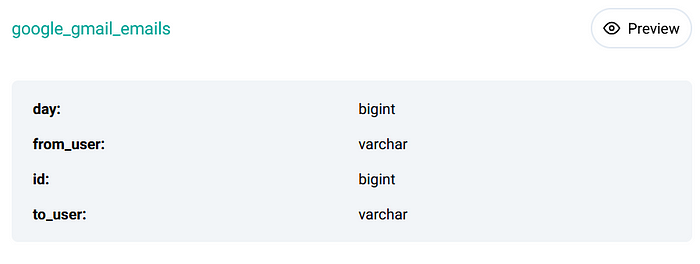

In [18]:
result = spark.sql("""
SELECT 

from_user, 
COUNT(*) as TotalEmails, 
DENSE_RANK() OVER (ORDER BY COUNT(id) DESC,from_user) as rank 

FROM 

google_gmail_emails

GROUP BY 

from_user

ORDER BY 

TotalEmails DESC,
from_user ASC
""")
result.show()

25/05/06 12:48:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/06 12:48:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/06 12:48:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/06 12:48:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/06 12:48:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/06 12:48:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/06 1

+---------------+-----------+----+
|      from_user|TotalEmails|rank|
+---------------+-----------+----+
|  bob@gmail.com|         22|   1|
|carol@gmail.com|         21|   2|
|alice@gmail.com|         20|   3|
| dave@gmail.com|         19|   4|
|  eve@gmail.com|         18|   5|
+---------------+-----------+----+



# Problem Statement:

Calculate the share of new and existing users for each month in the table. Output the month, share of new users, and share of existing users as a ratio. New users are defined as users who started using services in the current month (there is no usage history in previous months). Existing users are users who used services in current month, but they also used services in any previous month. Assume that the dates are all from the year 2020. HINT: Users are contained in user_id column Table: fact_events

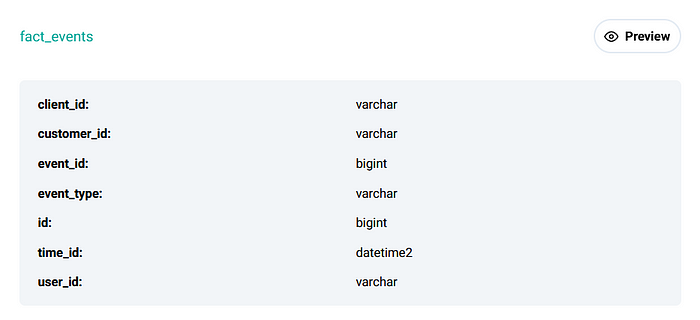

In [81]:
result = spark.sql("""
WITH user_first_month as (
SELECT 

user_id,
min(DATE_FORMAT(time_id, 'yyyy-MM')) as first_month

FROM 

fact_events

GROUP BY

user_id
),

user_month_status AS (
SELECT

e.user_id,
DATE_FORMAT(e.time_id, 'yyyy-MM') as month,
u1.first_month,

CASE

  WHEN DATE_FORMAT(e.time_id, 'yyyy-MM') = u1.first_month THEN 'new' 
  ELSE 'existing' 
END AS status

FROM 

fact_events e

JOIN

user_first_month u1 on e.user_id = u1.user_id


),

user_counts as (
SELECT 

month,
COUNT(DISTINCT CASE WHEN status = 'new' THEN user_id END) as new_users,
COUNT(DISTINCT CASE WHEN status = 'existing' THEN user_id END) as existing_users

FROM

user_month_status

GROUP BY

month

)

SELECT 
  month,
  new_users,
  existing_users,
  new_users * 1.0 / (new_users + existing_users) AS share_new_users,
  existing_users * 1.0 / (new_users + existing_users) AS share_existing_users
FROM user_counts
ORDER BY month
""")
result.show()


+-------+---------+--------------+------------------+--------------------+
|  month|new_users|existing_users|   share_new_users|share_existing_users|
+-------+---------+--------------+------------------+--------------------+
|2020-01|        5|             0|1.0000000000000000|  0.0000000000000000|
|2020-02|        5|             5|0.5000000000000000|  0.5000000000000000|
|2020-03|        5|            10|0.3333333333333333|  0.6666666666666667|
|2020-04|        5|             0|1.0000000000000000|  0.0000000000000000|
|2020-05|        0|            10|0.0000000000000000|  1.0000000000000000|
|2020-06|        5|             5|0.5000000000000000|  0.5000000000000000|
+-------+---------+--------------+------------------+--------------------+



# Problem Statement

This is hard level Spotify SQL interview question, published at stratascratch. Find the number of days a US track has stayed in the 1st position for both the US and worldwide rankings on the same day. Output the track name and the number of days in the 1st position. Order your output alphabetically by track name. If the region 'US' appears in dataset, it should be included in the worldwide ranking. Tables: spotify_daily_rankings_2017_us, spotify_worldwide_daily_song_ranking

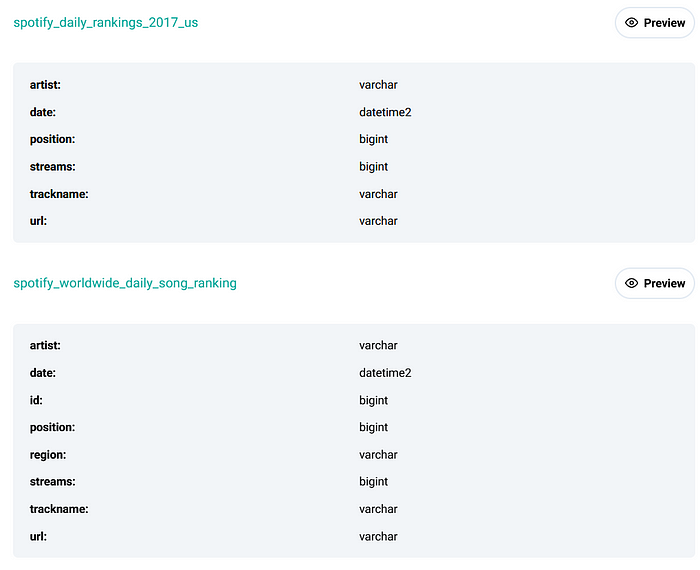


In [82]:
result = spark.sql(
"""

SELECT 

us.artist,
us.trackname,
count(us.date) as number_days


FROM spotify_daily_rankings_2017_us us

JOIN spotify_worldwide_daily_song_ranking world ON us.artist = world.artist AND us.date = world.date AND region = 'us'


GROUP BY

us.artist,
us.trackname

ORDER BY 

us.trackname ASC
"""

)

result.show()

+------------+-----------+-----------+
|      artist|  trackname|number_days|
+------------+-----------+-----------+
|  Bruno Mars|  24K Magic|          1|
|Taylor Swift|Blank Space|          1|
| Post Malone|   Rockstar|          1|
+------------+-----------+-----------+

